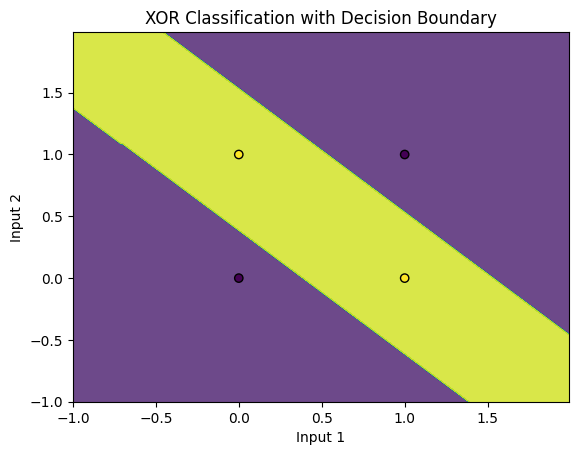

In [2]:
from abc import ABC, abstractmethod
import numpy as np
import matplotlib.pyplot as plt

# Activation interface
class Activation(ABC):
    @abstractmethod
    def output(self, x: np.ndarray) -> np.ndarray:
        pass

    @abstractmethod
    def derivative(self, x: np.ndarray) -> np.ndarray:
        pass

# Sigmoid implementation
class Sigmoid(Activation):
    def output(self, x: np.ndarray) -> np.ndarray:
        return 1 / (1 + np.exp(-x))

    def derivative(self, x: np.ndarray) -> np.ndarray:
        return x * (1 - x)

# Cost interface
class Cost(ABC):
    @abstractmethod
    def derivative(self, target: np.ndarray, output: np.ndarray) -> np.ndarray:
        pass

# MeanSquared implementation
class MeanSquared(Cost):
    def derivative(self, target: np.ndarray, output: np.ndarray) -> np.ndarray:
        return output - target

# Perceptron class
class Perceptron:
    def __init__(self, input_size: int, activation: Activation):
        self.weights = np.random.rand(input_size, 1)
        self.bias = np.random.rand(1, 1)
        self.activation = activation

    def feedforward(self, X: np.ndarray) -> np.ndarray:
        self.output = self.activation.output(np.dot(X, self.weights) + self.bias)
        return self.output

    def backward(self, X: np.ndarray, error: np.ndarray, learning_rate: float) -> np.ndarray:
        delta = error * self.activation.derivative(self.output)
        self.weights += X.T.dot(delta) * learning_rate
        self.bias += np.sum(delta, axis=0, keepdims=True) * learning_rate
        return np.dot(delta, self.weights.T)

# Layer class
class Layer:
    def __init__(self, input_size: int, num_neurons: int, activation: Activation):
        self.perceptrons = [Perceptron(input_size, activation) for _ in range(num_neurons)]

    def feedforward(self, X: np.ndarray) -> np.ndarray:
        return np.concatenate([perceptron.feedforward(X) for perceptron in self.perceptrons], axis=1)

    def backward(self, X: np.ndarray, errors: np.ndarray, learning_rate: float) -> np.ndarray:
        delta_accumulated = [perceptron.backward(X, errors[:, i:i+1], learning_rate) for i, perceptron in enumerate(self.perceptrons)]

        return np.concatenate(delta_accumulated, axis=1)

# NeuralNetwork class
class NeuralNetwork:
    def __init__(self, layers: list, cost: Cost):
        self.layers = layers
        self.cost = cost

    def train(self, input_data: np.ndarray, target_data: np.ndarray, epochs: int, learning_rate: float) -> None:
        for epoch in range(epochs):
            layer_input = input_data
            layer_outputs = [layer_input]

            # Forward pass
            for layer in self.layers:
                layer_output = layer.feedforward(layer_input)
                layer_outputs.append(layer_output)
                layer_input = layer_output

            # Backward pass
            output_error = self.cost.derivative(layer_output, target_data)
            for layer, layer_output in zip(reversed(self.layers), reversed(layer_outputs[:-1])):
                layer_input = layer.backward(layer_output, output_error, learning_rate)
                output_error = layer_input

    def predict(self, input_data: np.ndarray) -> np.ndarray:
        layer_input = input_data
        for layer in self.layers:
            layer_input = layer.feedforward(layer_input)
        return layer_input

# Training data
input_data = np.array([[0, 0], [0, 1], [1, 0], [1, 1]])
target_data = np.array([[0], [1], [1], [0]])

# Creating and training the neural network
activation_sigmoid = Sigmoid()
cost_mean_squared = MeanSquared()
hidden_layer_sigmoid = Layer(2, 3, activation=activation_sigmoid)
output_layer_sigmoid = Layer(3, 1, activation=activation_sigmoid)
nn_sigmoid = NeuralNetwork([hidden_layer_sigmoid, output_layer_sigmoid], cost=cost_mean_squared)
nn_sigmoid.train(input_data, target_data, epochs=10000, learning_rate=0.1)

# Create a meshgrid of points
h = 0.01
x_min, x_max = input_data[:, 0].min() - 1, input_data[:, 0].max() + 1
y_min, y_max = input_data[:, 1].min() - 1, input_data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
grid = np.c_[xx.ravel(), yy.ravel()]

# Predict the function value for the whole grid
Z = np.round(nn_sigmoid.predict(grid)).reshape(xx.shape)

# Plot the contour and training examples
plt.contourf(xx, yy, Z, alpha=0.8)
plt.scatter(input_data[:, 0], input_data[:, 1], c=target_data.ravel(), edgecolors='k')
plt.xlabel('Input 1')
plt.ylabel('Input 2')
plt.title('XOR Classification with Decision Boundary')
plt.show()
